In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def generate_data_4barplot(list_files):
    df_all = pd.DataFrame()
    for file_name in list_files:
        dbst = file_name[:-(len(file_pattern)+1)]
        if dbst=="":
            dbst="Metabolites"
        # read the CSV file into a pandas dataframe
        df_cv = pd.read_csv(DIR+file_name, index_col=0)
        # extract the first row of the dataframe
        avg_row = df_cv.iloc[0]
        sd_row = df_cv.iloc[1]
        df_avgsd = pd.DataFrame(columns=df_cv.columns)
        df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
        df_avgsd["best_avgAUC"]=avg_row.max() # collect best model avg AUC
        df_avgsd["best_model"]=avg_row.idxmax() # collect best model name
        df_avgsd["best_sdAUC"]= sd_row[avg_row.idxmax()]# collect best model sd AUC
        df_avgsd.index=[dbst]
        # append the second dataframe to the overall dataframe
        df_all = pd.concat([df_all, df_avgsd], axis=0)
    # replace model names
    df_all=df_all.replace({'RandomForest': 'Random Forest', 'linearSVM': 'SVM Linear', 'RBFSVM': 'SVM Radial', 'LogisticRegression': 'Logistic Regression', 'GradientBoosting': 'Gradient Boosting'})
    df_all.columns = ["SVM Linear", "SVM Radial", "Random Forest", "Gradient Boosting", "Adaboost", "Logistic Regression", "best_avgAUC", "best_model", "best_sdAUC"]
    df_all = df_all[["Random Forest", "Logistic Regression", "SVM Linear", "SVM Radial", "Gradient Boosting", "Adaboost", "best_avgAUC", "best_model", "best_sdAUC"]]
    # generate dataframe with db and st values in appropriate format
    dbst_df = pd.DataFrame(index=df_all.index.str.split("_").str[1].unique().dropna()) # remove gene row
    dbs=[db for db in df_all.index.str.split("_").str[0].unique().dropna() if db != "Metabolites"]

    for db in dbs:
        temp_df = df_all.loc[df_all.index.str.split("_").str[0] == db, ['best_avgAUC', 'best_model', 'best_sdAUC']]
        temp_df.columns = [temp_df.index[i].split("_")[0] + "_" + col.split("_")[1] for i, col in enumerate(temp_df.columns)]
        temp_df.index=temp_df.index.str.split("_").str[1].unique().dropna()

        # append the current dataframe to the new dataframe
        dbst_df = pd.concat([dbst_df, temp_df], axis=1)

    # generate gene-level data in appropriate format
    gene_df = df_all.loc["Metabolites", ['best_avgAUC', 'best_model', 'best_sdAUC']]
    gene_df = gene_df.rename({'best_avgAUC': 'Metabolites_avgAUC', 'best_model': 'Metabolites_model', 'best_sdAUC': 'Metabolites_sdAUC'})
    return(dbst_df, gene_df)

In [9]:
def generate_barplot(dbst_df, gene_df, savefig=True, path="./", name=None):
    agg = dbst_df.index.tolist()
    agg.append("single features")
    x_axis = np.arange(len(dbst_df.index))

    fig, ax = plt.subplots(figsize=(9, 8))
    bars = []
    bars.append(ax.bar(
        x_axis - 0.3, dbst_df['PW_avgAUC'], 0.3, tick_label=dbst_df.index, label="KEGG features",
        edgecolor='k', linewidth=2))
#    bars.append(ax.bar(#
#        x_axis, dbst_df['GOCC_avgAUC'], 0.3,
#        tick_label=dbst_df.index, label="GOCC features",
#        edgecolor='k', linewidth=2))
#    bars.append(ax.bar(
#        x_axis + 0.3, dbst_df['CORUM_avgAUC'], 0.3, tick_label=dbst_df.index,
#        label="CORUM features", edgecolor='k', linewidth=2))
    bars.append(ax.bar(
        x_axis[-1] + 0.8, gene_df['Metabolites_avgAUC'], 0.3, tick_label="Metabolites",
        label="Metabolites", edgecolor='k', linewidth=2))

    for bar_group in bars:
        db=bar_group.get_label().split(" ")[0]
        for j, bar in enumerate(bar_group):
            if db != "Metabolites":
                ax.text(bar.get_x() + bar.get_width() / 2, 0.3, dbst_df[db + '_model'][j], color='white', ha='center', va='center', fontweight='bold', rotation=90)
                #ax.text(x_axis[-1] + 0.8, 0.3 , gene_df['best_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, 0.3, gene_df[db + '_model'], color='white', ha='center', va='center', fontweight='bold', rotation=90)

#    ax.errorbar(
#        x_axis - 0.3, dbst_df['GOBP_avgAUC'], yerr=dbst_df['GOBP_sdAUC'],
#        fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
#        ms=4, capsize=5)
#    ax.errorbar(
#        x_axis, dbst_df['GOCC_avgAUC'], yerr=dbst_df['GOCC_sdAUC'],
#        fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
#        ms=4, capsize=5)
#    ax.errorbar(
#        x_axis + 0.3, dbst_df['CORUM_avgAUC'], yerr=dbst_df['CORUM_sdAUC'],
#        fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
#        ms=4, capsize=5)
#    ax.errorbar(
#        x_axis[-1] + 0.8, gene_df['GENE_avgAUC'], yerr=gene_df['GENE_sdAUC'],
#        fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
#        ms=4, capsize=5)

    ax.set_xticks(np.append(x_axis, 4.8))
    ax.set_xticklabels(agg)
    ax.set_ylabel('Average 10-folds AUC')       # Label on Y axis
    ax.set_ylim((0, 1))
    plt.legend()
    if savefig==True:
        if not name:
            name="Barplot_AUC_DBvsST_BL.pdf"
        plt.savefig(path + name)
    plt.show()


In [10]:
def generate_barplot(dbst_df, metab_df, savefig=True, path="./", name="Barplot_AUC_DBvsST_BL.pdf"):
    fig, ax = plt.subplots(figsize=(6, 6))
    bar_width = 0.3  # Adjust the width of the bars
    bars = []
    bars.append(
    ax.bar(dbst_df.index, dbst_df['PW_avgAUC'], yerr=dbst_df['PW_sdAUC'], capsize=5, width=bar_width, label="KEGG features", edgecolor='k', linewidth=2),
    ax.bar("single features", metab_df['Metabolites_avgAUC'], yerr=metab_df['Metabolites_sdAUC'], capsize=5, width=bar_width, label="Metabolites", edgecolor='k', linewidth=2)
    )
    # Add model names inside the Metabolites bars
    for bar, model in zip(metab_bars, metab_df['Metabolites_model']):
        ax.text(bar.get_x() + bar.get_width() / 2, 0.3, model, color='white', ha='center', va='center', fontweight='bold', rotation=90)

    for bar_group in bars:
        db=bar_group.get_label().split(" ")[0]
        for j, bar in enumerate(bar_group):
            if db != "Metabolites":
                ax.text(bar.get_x() + bar.get_width() / 2, 0.3, dbst_df[db + '_model'][j], color='white', ha='center', va='center', fontweight='bold', rotation=90)
                #ax.text(x_axis[-1] + 0.8, 0.3 , gene_df['best_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, 0.3, gene_df[db + '_model'], color='white', ha='center', va='center', fontweight='bold', rotation=90)


    ax.set_ylabel('Average 10-folds AUC')  # Label on Y axis
    ax.set_ylim((0, 1))
    ax.legend()

    if savefig:
        plt.savefig(path + name)
    plt.show()

/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_1079/2262321277.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dbst_labels, rotation=20, ha='right')


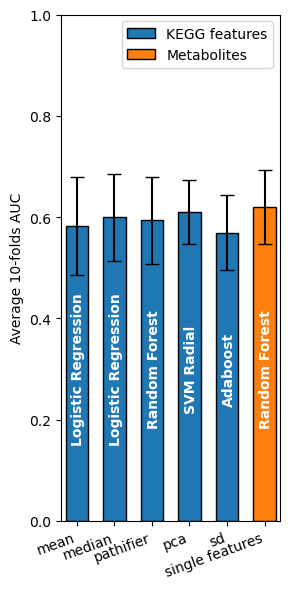

In [11]:
dbst_df, metab_df= df_agg, df_metab
fig, ax = plt.subplots(figsize=(3, 6))
bar_width = 0.6  # Adjust the width of the bars
bars = []

bars.append(ax.bar(dbst_df.index, dbst_df['PW_avgAUC'], yerr=dbst_df['PW_sdAUC'], capsize=5, width=bar_width, label="KEGG features", edgecolor='k', linewidth=1, align='center'))
bars.append(ax.bar("single features", metab_df['Metabolites_avgAUC'], yerr=metab_df['Metabolites_sdAUC'], capsize=5, width=bar_width, label="Metabolites", edgecolor='k', linewidth=1, align='center'))

for bar_group in bars:
    db=bar_group.get_label().split(" ")[0]
    for j, bar in enumerate(bar_group):
        if db != "Metabolites":
            db="PW"
            ax.text(bar.get_x() + bar.get_width() / 1.75, 0.3, dbst_df[db + '_model'][j], color='white', ha='center', va='center', fontweight='bold', rotation=90)
            #ax.text(x_axis[-1] + 0.8, 0.3 , gene_df['best_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
        else:
            ax.text(bar.get_x() + bar.get_width() / 1.75, 0.3, metab_df[db + '_model'], color='white', ha='center', va='center', fontweight='bold', rotation=90)
# x labels
dbst_labels = list(dbst_df.index)  
dbst_labels.append("single features")  
ax.set_xticklabels(dbst_labels, rotation=20, ha='right')
ax.set_ylabel('Average 10-folds AUC')  # Label on Y axis
ax.set_ylim((0, 1))
ax.legend()
ax.margins(x=0.02)
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()



In [12]:
def generate_barplot(ax, df, measurement_name, shared_yax=False, y_label=True):
    df_aggs=df[0]
    df_single=df[1]
    bar_width = 0.7  # Adjust the width of the bars
    bars = []

    bars.append(ax.bar(df_aggs.index, df_aggs['PW_avgAUC'], yerr=df_aggs['PW_sdAUC'], capsize=5, width=bar_width, label="KEGG features", color='b', alpha=0.7, edgecolor='k', linewidth=1, align='center'))
    bars.append(ax.bar("single features", df_single['Metabolites_avgAUC'], yerr=df_single['Metabolites_sdAUC'], capsize=5, width=bar_width, label="Metabolites", color='r', alpha=0.7, edgecolor='k', linewidth=1, align='center'))

    for bar_group in bars:
        db = bar_group[0].get_label().split(" ")[0]  # Use the first bar's label to get the category (KEGG or Metabolites)
        for j, bar in enumerate(bar_group):
            if db != "Metabolites":
                db = "PW"
                ax.text(bar.get_x() + bar.get_width() / 1.75, 0.02, df_aggs[db + '_model'][j], color='white', ha='center', va='bottom', fontweight='bold', rotation=90)
            else:
                ax.text(bar.get_x() + bar.get_width() / 1.75, 0.02, df_single[db + '_model'][j], color='white', ha='center', va='bottom', fontweight='bold', rotation=90)

    xlabels = list(df_aggs.index)  
    xlabels.append("single features")  
    ax.set_xticklabels(xlabels, rotation=20, ha='right')
    if y_label:
        ax.set_ylabel('Average 10-folds AUC')
    ax.set_ylim((0, 1))
    ax.set_title(measurement_name)


In [14]:
def generate_multibarplot(n_plots, titles, df_list, name, path="./", savefig=True):
    # Create a multiplot figure with three subplots
    fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(10, 6), sharey=True, gridspec_kw={'hspace': 0.9, 'hspace': 0.1})

    # Generate barplots for each measurement
    generate_barplot(axes[0], df_list[0], titles[0], shared_yax=(0, 1), y_label=True)
    generate_barplot(axes[1], df_list[1], titles[1], y_label=False)
    generate_barplot(axes[2], df_list[2], titles[2], y_label=False)

    # Adjust legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.subplots_adjust(wspace=0.08)
    plt.tight_layout()  # Adjust layout to prevent labels from being cut off
    if savefig==True:
        if not name:
            name="Barplot_AUC_DBvsST_BL.pdf"
        plt.savefig(path + name)
    plt.show()

/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_1079/2789650335.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_1079/2789650335.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_1079/2789650335.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_1079/2789650335.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

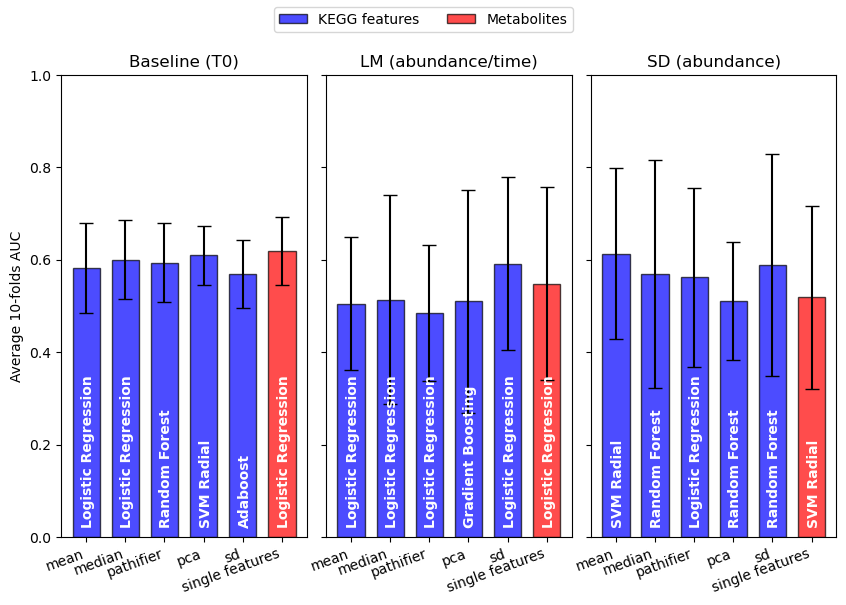

In [16]:
# BL
DIR = 'results/'
list_files = os.listdir(DIR)
list_files.sort()
file_pattern = 'results_nestedCV_UPDRS__3_binary.csv'
list_files = [file for file in list_files if file_pattern in file]
df_agg, df_metab = generate_data_4barplot(list_files)

# lm-time
DIR = 'results/ts/classification/'
list_files = os.listdir(DIR)
list_files.sort()
file_pattern = 'lm-time_results_nestedCV_UPDRS__3_binary.csv'
list_files = [file for file in list_files if file_pattern in file]
df_agg_lm, df_metab_lm = generate_data_4barplot(list_files)

# sd
DIR = 'results/ts/classification/'
list_files = os.listdir(DIR)
list_files.sort()
file_pattern = 'sd_results_nestedCV_UPDRS__3_binary.csv'
list_files = [file for file in list_files if file_pattern in file]
df_agg_sd, df_metab_sd = generate_data_4barplot(list_files)

generate_multibarplot(n_plots=3, titles=["Baseline (T0)","LM (abundance/time)", "SD (abundance)"], df_list=[[df_agg, df_metab], [df_agg_lm, df_metab_lm], [df_agg_sd, df_metab_sd]], savefig=True, name="Barplot_AUC_DBvsST_BL.pdf", path="../reports/PRED-V0-TS-UPDRS_3_results/")


#generate_barplot(df_agg, df_metab, savefig=True, path="./", name="Barplot_AUC_DBvsST_BL.pdf")

In [128]:
DIR = 'results/ts/classification/'
list_files = os.listdir(DIR)
list_files.sort()
file_pattern = 'lm-time_results_nestedCV_UPDRS__3_binary.csv'
list_files = [file for file in list_files if file_pattern in file]
list_files
df_agg, df_metab = generate_data_4barplot(list_files)

#generate_barplot(df_agg, df_gene, savefig=True, path="./", name="Barplot_AUC_DBvsST_TS-LMLAG.pdf")

/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_53834/2789650335.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_53834/2789650335.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_53834/2789650335.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_53834/2789650335.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

Metabolites_avgAUC         0.705556
Metabolites_model     Random Forest
Metabolites_sdAUC          0.203078
Name: Metabolites, dtype: object

In [41]:
df_all

,Random Forest,Logistic Regression,SVM Linear,SVM Radial,Gradient Boosting,Adaboost,best_avgAUC,best_model,best_sdAUC
CORUM_mean,0.542711,0.533166,0.605064,0.540639,0.635957,0.566176,0.635957,Logistic Regression,0.079787
CORUM_median,0.512007,0.547170,0.522861,0.517472,0.568026,0.511258,0.568026,Logistic Regression,0.054084
CORUM_pathifier,0.579643,0.570477,0.620048,0.574368,0.608200,0.564750,0.620048,SVM Linear,0.103540
CORUM_pca,0.544672,0.498953,0.542293,0.542736,0.587684,0.484952,0.587684,Logistic Regression,0.082087
CORUM_sd,0.606874,0.610971,0.656684,0.589550,0.669920,0.613592,0.669920,Logistic Regression,0.064123
GOBP_mean,0.638614,0.629178,0.632651,0.639639,0.664611,0.573229,0.664611,Logistic Regression,0.084995
GOBP_median,0.569814,0.555531,0.594313,0.543405,0.608434,0.541449,0.608434,Logistic Regression,0.059689
GOBP_pathifier,0.576638,0.565982,0.607537,0.555242,0.600925,0.549554,0.607537,SVM Linear,0.062537
GOBP_pca,0.595613,0.548669,0.564121,0.597869,0.593349,0.501223,0.597869,Adaboost,0.066604
GOBP_sd,0.571020,0.598663,0.600875,0.561174,0.605905,0.551977,0.605905,Logistic Regression,0.110485


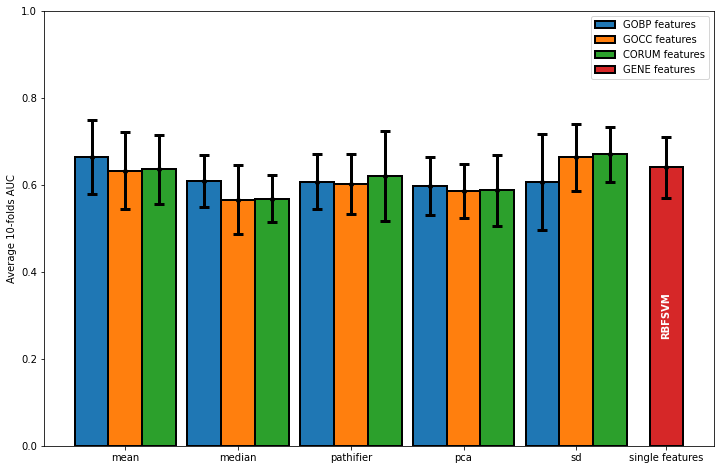

In [286]:
agg = dbst_df.index.tolist()
agg.append("single features")
x_axis = np.arange(len(dbst_df.index))

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(
    x_axis - 0.3, dbst_df['GOBP_avgAUC'], yerr=dbst_df['GOBP_sdAUC'],
    fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
    ms=4, capsize=5)
ax.errorbar(
    x_axis, dbst_df['GOCC_avgAUC'], yerr=dbst_df['GOCC_sdAUC'],
    fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
    ms=4, capsize=5)
ax.errorbar(
    x_axis + 0.3, dbst_df['CORUM_avgAUC'], yerr=dbst_df['CORUM_sdAUC'],
    fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
    ms=4, capsize=5)
ax.errorbar(
    x_axis[-1] + 0.8, gene_df['GENE_avgAUC'], yerr=gene_df['GENE_sdAUC'],
    fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
    ms=4, capsize=5)
ax.bar(
    x_axis - 0.3, dbst_df['GOBP_avgAUC'], 0.3, tick_label=dbst_df.index, label="GOBP features",
    edgecolor='k', linewidth=2)
ax.bar(
    x_axis, dbst_df['GOCC_avgAUC'], 0.3,
    tick_label=dbst_df.index, label="GOCC features",
    edgecolor='k', linewidth=2)
ax.bar(
    x_axis + 0.3, dbst_df['CORUM_avgAUC'], 0.3, tick_label=dbst_df.index,
    label="CORUM features", edgecolor='k', linewidth=2)
ax.bar(
    x_axis[-1] + 0.8, gene_df['GENE_avgAUC'], 0.3, tick_label="GENE",
    label="GENE features", edgecolor='k', linewidth=2)
#ax.text(x_axis - 0.3, 0.3 , dbst_df['GOBP_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
#ax.text(x_axis, 0.3 , dbst_df['GOCC_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
#ax.text(x_axis + 0.3, 0.3 , dbst_df['CORUM_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
ax.text(x_axis[-1] + 0.8, 0.3 , gene_df['GENE_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
ax.set_xticks(np.append(x_axis, 4.8))
ax.set_xticklabels(agg)
ax.set_ylabel('Average 10-folds AUC')       # Label on Y axis
ax.set_ylim((0, 1))
plt.legend()
#plt.savefig(dir_results + "cv_performance_DBvsST.pdf")
plt.show()


<AxesSubplot:>

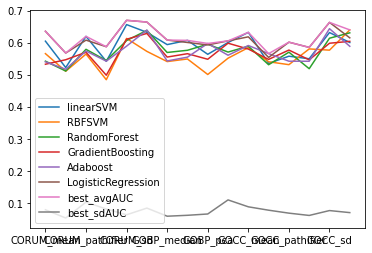

In [288]:
df_all.plot()